In [1]:
import pandas as pd
import pickle
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import matplotlib.pyplot as plt
import lightgbm as lgb
from collections import Counter
%matplotlib inline

#### Pandas dataframes column names

In [2]:
LOG_COUNTS                 = 'LogCounts'
LOG_TIMES                  = 'LogTimes'
TIMES                      = 'Times'
COUNTS                     = 'Counts'
EXT_DATA                   = 'NaN extra data'
PASSWORD                   = 'Password'
PASSWORD_LENGTH            = 'password_len'
SEPARATED_WORDS            = 'separated_words'
NUMBER_WORDS               = 'N_all_words'
NUMBER_SEPARATES_NUMBERS   = 'N_digit_words'
NUMBER_SMALL_CAPS_WORDS    = 'N_small_caps_words'
NUMBER_BIG_CAPS_WORDS      = 'N_big_caps_words'
NUMBER_SYMBOL_WORDS        = 'N_symbol_words'
POSSIBLE_DATES             = 'Possible_dates'
NUMBER_POSSIBLE_DATES      = 'N_possible_dates'
KEYBOARD_NEIGHBOURS_COEF   = 'Keyboard_neighbours'
AlPHABET_NEIGHBOURS_COEF   = 'Alphabet_neighbours'
TOP_1M                     = 'Top 1M'
TOP_100K                   = 'Top 100k'
TOP_10K                    = 'Top 10k'
TOP_1K                     = 'Top 1k'
TOP_500                    = 'Top 500'
TOP_100                    = 'Top 100'
POSITION                   = 'Position'
NAME_EN_FEMALE             = 'Female name EN'
NAME_EN_MALE               = 'Male name EN'
SURNAME_EN                 = 'Surname EN'
WORD                       = 'Word'

#### Import of data

In [3]:
#import data
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/Xtest.csv')
data_external = pd.read_csv('./data/rockyou_with_spaces.csv')

#delete rows with NaN values
data_train = data_train.dropna(axis=0)
data_test = data_test.dropna(axis=0)
# in data_test id 581317 has NaN in Password. Don't forget to fill prediction for id=581317 latter

data_train[LOG_TIMES] = np.log(data_train[TIMES])

#### Adding new feature COUNTS from http://downloads.skullsecurity.org/passwords/rockyou-withcount.txt.bz2

In [4]:
data_train = data_train.merge(right=data_external , left_on=PASSWORD, right_on=PASSWORD, how = 'left')
data_test = data_test.merge(right=data_external , left_on=PASSWORD, right_on=PASSWORD, how = 'left')

#if there is no password from out dataset in external dataset, COUNT = 1
data_train[EXT_DATA] = data_train[COUNTS].isna()
data_test[EXT_DATA] = data_test[COUNTS].isna()

data_train[EXT_DATA] = data_train[EXT_DATA].astype(int)
data_test[EXT_DATA] = data_test[EXT_DATA].astype(int)

data_train[COUNTS].fillna(1,inplace=True)
data_test[COUNTS].fillna(1,inplace=True)

#Let's log COUNTS
data_train[LOG_COUNTS] = np.log(data_train[COUNTS])
data_test[LOG_COUNTS] = np.log(data_test[COUNTS])

#### Adding new features with top passwords list files from repository


https://github.com/danielmiessler/SecLists/tree/master/Passwords/Common-Credentials

In [5]:
top_list = [TOP_1M,TOP_100K,TOP_10K,TOP_1K,TOP_500,TOP_100]
top_files = ['top_1M.txt','top100k.txt','top10k.txt','top1k.txt','top500.txt','top100.txt']

for top_name, filename in zip(top_list, top_files):
    
    top_df = pd.read_csv('./data/' + filename)
    top_df[top_name] = 1
    
    #Add position in list as another feature
    if top_name == TOP_1M:
        top_df[POSITION] = np.arange(top_df.shape[0])[::-1]
        
    
    data_train = data_train.merge(right=top_df, left_on=PASSWORD, right_on=PASSWORD, how = 'left')
    data_test  = data_test.merge(right=top_df, left_on=PASSWORD, right_on=PASSWORD, how = 'left')
    
    
    data_train[top_name].fillna(0,inplace=True)
    data_test[top_name].fillna(0,inplace=True)
    
    if top_name == TOP_1M:
        data_train[POSITION].fillna(0,inplace=True)
        data_test[POSITION].fillna(0,inplace=True)
            
# data_test = data_test.merge(right=data_external , left_on=PASSWORD, right_on=PASSWORD, how = 'left')

#### Let names and surname wil be also features.

https://github.com/dropbox/zxcvbn/tree/master/data

In [6]:
my_list = [NAME_EN_MALE,NAME_EN_FEMALE,SURNAME_EN]
my_files = ['en_male_names.txt','en_female_names.txt','en_surnames.txt']
for name, filename in zip(my_list, my_files):
    df = pd.read_csv('./data/zxcvbn/' + filename)
    df[name] = 1
    
    data_train = data_train.merge(right=df, left_on=PASSWORD, right_on=PASSWORD, how = 'left')
    data_test  = data_test.merge(right=df, left_on=PASSWORD, right_on=PASSWORD, how = 'left')
    
    data_train[name].fillna(0,inplace=True)
    data_test[name].fillna(0,inplace=True)
# data_test = data_test.merge(right=data_external , left_on=PASSWORD, right_on=PASSWORD, how = 'left')

#### Some functions for features extracting

In [8]:
def keyboard_neighbourhood_measure(string):
    """
    This function uses next_keyboard_char_dict for measuring
    which part of all symbols in word in keyboard order.
    If there is symbol[i+1] is there dictionary[symbol[i]], counter is increased by 1.
    After counting, the counter is divided by word's length.
    """
    string_length = len(string)
    if string_length  > 1:
        counter = 0
        for i in range(string_length - 1):
            char = string[i]
            next_char = string[i+1]
            if char in next_keyboard_char_dict.keys():
                if next_char in next_keyboard_char_dict[char]:
                    counter += 1
            else:
#                 print('ASCI code:'  + str(ord(char)))
                pass
        return counter/(string_length - 1)
    elif string_length == 1:
        return 0.5
    else:
        return 1

next_keyboard_char_dict = {
    '`': '1az',       '~': '1AZ',
    '1': '`12q',      '!': '~!@Q',
    '2': '123qw',     '@': '!@#QW',
    '3': '234we',     '#': '@#$WE',
    '4': '345ert',    '$': '#$%ER',
    '5': '456rty',    '%': '$%^RT',
    '6': '567tyu',    '^': '%^&TY',
    '7': '678tyu',    '&': '^&*YU',
    '8': '789uio',    '*': '&*(UI',
    '9': '890iop',    '(': '*()IO',
    '0': '90-op[',    ')': '()_OP',
    '-': '0-=p[]',    '_': ')_+P{',
    '=': '-[]+',      '+': '_+{}',
    'q': '12qwas',    'Q': '!QA@W',   
    'w': '123qweasd', 'W': '@WS#EQA',
    'e': '234wersdf', 'E': '#WSDER$',
    'r': '345ertdfg', 'R': '$%ERTDF',
    't': '456rtyfgh', 'T': '%^RTYFG',
    'y': '567tyughj', 'Y': '^&TYUGH', 
    'u': '678yuihjk', 'U': '&*YUIHJ',
    'i': '789uiojkl', 'I': '*(UIOJK',
    'o': '890iopkl;', 'O': '()IOPKL',
    'p': "90-op[l;'", 'P': ')_OP{L:',
    '[': "0-=p[];'\\",'{': '_+P{}:"',
    ']': "-=[\\']",   '}': '+{}"|',
    'a':'qazwsx',     'A': 'QWASZ|',
    's':'qazwsxedc',  'S': 'WEASDZX',
    'd':'wsxedcrfv',  'D': 'ERSDFXC',
    'f': 'edcrfvtgb', 'F': 'RTDFGCV',
    'g': 'rfvtgbyhn', 'G': 'TYFGHVB',
    'h': 'tgbyhnujm', 'H': 'YUGHJBN',
    'j': 'yhnujmik,', 'J': 'UIHJKNM',
    'k': 'ujmik,ol.', 'K': 'IOJLM<',
    'l': "ik,ol.p;/", 'L': 'OPK:L<>',
    ';': "ol.p;/[']", ':': 'L:"OP{>?',
    "'": "p[];'\\/",  '"': ':"|{}?',
    "\\": "[]'\\/",   '|': '"|{}?"AZ',
    'z': 'aszx\\',    'Z': 'ASX|',
    'x': 'asdzxc',    'X': 'ZSDCX',
    'c': 'sdfxcv',    'C': 'XDFVC',  
    'v': 'dfgcvb',    'V': 'CFGBV',
    'b': 'fghvbn',    'B': 'VGHNB',
    'n': 'ghjbnm',    'N': 'BHJMN',
    'm': 'hjknm,',    'M': 'NJK<M',
    ',': 'jklm,.',    '<': 'MKL><',
    '.': 'kl;,./',    '>': '<L:?>',
    '/': ";'\\/z",    '?': '>:"?'
}

    
alphabet = '0123456789QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'

def alphabet_sequnce_measure(string):
    """
    This function measure how many letters in a word in alphabetic order.
    If letter[i+1] after letter[i] counter is increased by 1.
    After counting, the counter is divided by word's length.
    """
    string_length = len(string)
    if string_length  > 1:
        counter = 0
        for i in range(string_length - 1):
            char = string[i]
            next_char = string[i+1]
            if char in alphabet:
                if ord(char) + 1 == ord(next_char):
                    counter += 1
            else:
                pass
#                 print('Char is not in alphabet and number. ASCI code' + str(ord(char)))
        return counter/(string_length - 1)
    elif string_length == 1:
        return 0.5
    else:
        return 1

    
def is_it_date(string_array):
    """
    This function analyses if string is possibly date or not.
    It analyzes XXXX, XXXXXX, XXXXXXX strings consisting of digits.
    """
    counter = 0
    string_array_counter = Counter(string_array)
    for string in string_array:
        if string_array_counter[string] >= 1:
            
            string_array_counter[string] -= 1
            string_length = len(string)
            
            if string_length == 4 or string_length == 6:
                str1 = string[0:2]
                num1 = int(str1)
                str2 = string[2:4]
                num2 = int(str2)
                num  =  int(string)
                if (num1 <= 12 and num2 <= 31) or (num1 <= 31 and num2 <= 12):
                    counter += 1

                elif num >= 1000 and num <= 2019:
                    counter += 1

            elif string_length == 8:
                str1 = string[0:2]
                str2 = string[2:4]
                str3 = string[4:]
                num1 = int(str1)
                num2 = int(str2)
                num3 = int(str3)

                str4 = string[0:4]
                str5 = string[4:6]
                str6 = string[6:]
                num4 = int(str4)
                num5 = int(str5)
                num6 = int(str6)

                if ((num1 <= 12 and num2 <= 31) or (num1 <= 31 and num2 <= 12)) and (num3 >= 1000 and num3 <= 2019):
                    counter += 1

                elif ((num5 >= 10 and num6 <= 31) or (num5 <= 31 and num6 <= 12)) and (num4 >= 1000 and num4 <= 2019):
                    counter += 1
                
    return counter

English dictionary from https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt

In [34]:
df = pd.read_csv('./data/words_alpha.txt')
df[WORD] = 1
data_train = data_train.merge(right=df, left_on=PASSWORD, right_on=PASSWORD, how = 'left')
data_test  = data_test.merge(right=df, left_on=PASSWORD, right_on=PASSWORD, how = 'left')
data_train[WORD].fillna(0,inplace=True)
data_test[WORD].fillna(0,inplace=True)

#### Utilits for error estimating, predicting and saving submissions for test data

In [10]:
from sklearn.metrics import mean_squared_log_error

#Kaggle error metric
def error(log_y, log_pred):
    return np.sqrt(mean_squared_log_error(np.exp(log_y), np.exp(log_pred)))


def save_submission(preds_test, submission_filename):
    #Check for prediction array size
    if preds_test.shape[0] == 1037875 - 1:
        preds_test = np.insert(preds_test,581317,1)
    assert(preds_test.shape[0] == 1037875) #Check submission array length

    #Constructing pandas.DataFrame for saving submissions
    ids = np.arange(len(preds_test))
    df = pd.DataFrame({'Id':ids, 'Times':preds_test})
    df = df.set_index('Id')
    #Save submissions
    df.to_csv(submission_filename)

def predict_and_save_submission(model, X_test, filename):
    # pred_test = model.predict(X_test)
    preds_test = model.predict(X_test)
    preds_test = np.exp(preds_test) #возводим обратно в exp
    save_submission(preds_test,filename)

def train_val_error(model,error):
    """
    Evalute error on train/validation data
    """
    preds_train = model.predict(X_train[cols])
    preds_val = model.predict(X_val[cols])
    print('Test data error: %.4f' %error(y_train,preds_train))
    print('Valifation data error: %.4f' %error(y_val,preds_val))

#### Exctructing basic informations from text using regular expressions

In [11]:
%%time
#Regularexprission patterns 
# pattern_for_date_recognition1 = r'\d{2}[-/_]\d{2}[-/_]\d{4}|\d{4}[-/_]\d{2}[_/-]\d{2}|\d{2}[_/-]\d{2}[_/-]\d{2}|\d{8}|\d{6}'
pattern_for_date_recognition1 = r'\d{8}|\d{6}|\d{4}'
# pattern_for_date_recognition2 = r'(\d{2})[-/_](\d{2})[-/_](\d{4})|(\d{4})[-/_](\d{2})[_/-](\d{2})|(\d{2})[_/-](\d{2})[_/-](\d{2})|(\d{8})|(\d{6})'
pattern_for_allwords_extraction = r'[a-zA-Z]+|\d+|\W+|\_+'


#Get features from passwords
for df in [data_train,data_test]:
    df[PASSWORD_LENGTH]                    = df[PASSWORD].str.len()
    df[SEPARATED_WORDS]                    = df[PASSWORD].str.findall(pattern_for_allwords_extraction)
    df[NUMBER_WORDS]                       = df[SEPARATED_WORDS].apply(lambda x: len(x))
    df[NUMBER_SEPARATES_NUMBERS]           = df[PASSWORD].str.count(r'(\d+)')
    df[NUMBER_SMALL_CAPS_WORDS]            = df[PASSWORD].str.count(r'[a-z]+')
    df[NUMBER_BIG_CAPS_WORDS]              = df[PASSWORD].str.count(r'[A-Z]+')
    df[NUMBER_SYMBOL_WORDS]                = df[PASSWORD].str.count(r'\W+')
#     df[KEYBOARD_NEIGHBOURS_COEF]           = df[PASSWORD].apply(keyboard_neighbourhood_measure)

Wall time: 19 s


In [12]:
%%time
for df in [data_train, data_test]:
    df[POSSIBLE_DATES]                     = df[PASSWORD].str.findall(pattern_for_date_recognition1)
    df[NUMBER_POSSIBLE_DATES]              = df[POSSIBLE_DATES].apply(is_it_date)

Wall time: 13.7 s


In [13]:
%%time
for df in [data_train,data_test]:
    df[KEYBOARD_NEIGHBOURS_COEF]           = df[PASSWORD].apply(keyboard_neighbourhood_measure)

Wall time: 7.87 s


In [14]:
%%time
for df in [data_train,data_test]:
    df[AlPHABET_NEIGHBOURS_COEF]           = df[PASSWORD].apply(alphabet_sequnce_measure)

Wall time: 8.81 s


#### Let all symbols will be features

In [15]:
letters_list1 = '0123456789QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
letters_list1 = list(letters_list1)
col_names1 = letters_list1

for letter in letters_list1:
    for df in [data_train, data_test]:
        df[letter]  = df[PASSWORD].str.count(letter)

In [16]:
letters_list2 =  '[]/\^$.|?*+(){}'
letters_list2 = list(letters_list2)
col_names2 = []
for i in range(len(letters_list2)):
    col_name = 'Special symbol A '+ str(i)
    col_names2.append(col_name)
    for df in [data_train, data_test]: 
        df[col_name]  = df[PASSWORD].str.count('\\'+letters_list2[i])

In [17]:
letters_list3 = ',:!±§`~_-=&#@<>%'
letters_list3 = list(letters_list3)
col_names3 = []

for j in range(len(letters_list3)):
    col_name = 'Special symbol B '+ str(j)
    col_names3.append(col_name)
    for df in [data_train, data_test]: 
        df[col_name]  = df[PASSWORD].str.count(letters_list3[j])

In [18]:
data_train.sample(10)

,Password,Times,LogTimes,Counts,NaN extra data,LogCounts,Top 1M,Position,Top 100k,Top 10k,...,Special symbol B 6,Special symbol B 7,Special symbol B 8,Special symbol B 9,Special symbol B 10,Special symbol B 11,Special symbol B 12,Special symbol B 13,Special symbol B 14,Special symbol B 15
1958404,pumiracub,1,0.000000,1.0,1,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
413402,valerkolomakin,4,1.386294,1.0,1,0.000000,1.0,808084.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1295773,ferrarimrmumbles,1,0.000000,1.0,1,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
291753,hmoncyka,1,0.000000,1.0,1,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3153726,snefru,1,0.000000,2.0,0,0.693147,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2456952,melisandra,1,0.000000,2.0,0,0.693147,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1876236,m188,2,0.693147,1.0,1,0.000000,1.0,502075.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1001458,853233202,1,0.000000,1.0,1,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1548081,1226grand,1,0.000000,1.0,0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3428033,8XppH5LYsy9t,1,0.000000,1.0,1,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Splitting dataset to train/validation

In [39]:
# Choose data for train
y = data_train[LOG_TIMES].values #логарифмируем таргет
X = data_train
val_size = 0.2 #Validation data size
seed = 32      #Random seed 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=seed)

Choose columns from dataframe which is used as features

In [40]:
cols = [PASSWORD_LENGTH,
        NUMBER_WORDS,
        NUMBER_SMALL_CAPS_WORDS,
        NUMBER_BIG_CAPS_WORDS,
        NUMBER_SYMBOL_WORDS,
        NUMBER_POSSIBLE_DATES,
        KEYBOARD_NEIGHBOURS_COEF,
        AlPHABET_NEIGHBOURS_COEF,
        LOG_COUNTS,
#         COUNTS,
        TOP_1M,                     
        TOP_100K,                   
        TOP_10K,                 
        TOP_1K,                  
        TOP_500,          
        TOP_100,
        POSITION,
        NAME_EN_FEMALE,
        NAME_EN_MALE,
        SURNAME_EN,
        WORD
       ]
cols = cols + col_names1 + col_names2 + col_names3

### Linear Regression

For fast features analysis linear regression is used

In [41]:
from sklearn.linear_model import LinearRegression
# Choose the type of classifier. 
model_lin = LinearRegression()
model_lin.fit(X_train[cols], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Analyze coefficients of liner regression estimator

Text(0.5,1,'Linear regression coeffients')

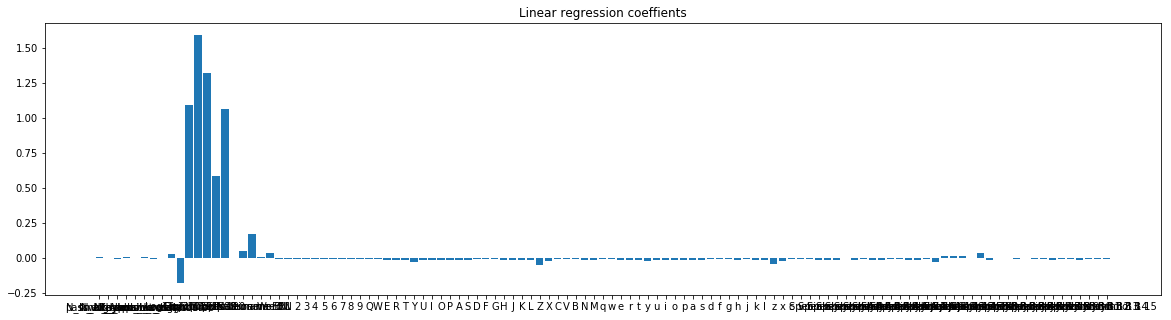

In [42]:
w = model_lin.coef_
plt.figure(figsize = (20,5))
x = np.arange(len(w))
plt.bar(x,w)
plt.xticks(x, cols)
plt.title('Linear regression coeffients')

In [43]:
train_val_error(model_lin,error)

Test data error: 0.0804
Valifation data error: 0.0808


In [241]:
predict_and_save_submission(model_lin, data_test[cols], 'sub_lin_6_with_new_features.csv')

### LightGBM

In [51]:
d_train = lgb.Dataset(X_train[cols], label = y_train)
# d_train.save_binary('lgb_train.bin')
d_val = d_train.create_valid(X_val[cols], label = y_val)
# d_val.save_binary('lgb_val.bin')

parameters = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'num_trees': 50,
    'num_iterations': 3000,
    'learning_rate': 1e-2
}

model_lgb = lgb.train(parameters, d_train, valid_sets=d_val)
# model_lgb = lgb.train(parameters, d_train)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.541336
[2]	valid_0's rmse: 0.535924
[3]	valid_0's rmse: 0.530566
[4]	valid_0's rmse: 0.525262
[5]	valid_0's rmse: 0.520012
[6]	valid_0's rmse: 0.514814
[7]	valid_0's rmse: 0.509668
[8]	valid_0's rmse: 0.504573
[9]	valid_0's rmse: 0.49953
[10]	valid_0's rmse: 0.494537
[11]	valid_0's rmse: 0.489594
[12]	valid_0's rmse: 0.4847
[13]	valid_0's rmse: 0.479855
[14]	valid_0's rmse: 0.475059
[15]	valid_0's rmse: 0.470311
[16]	valid_0's rmse: 0.46561
[17]	valid_0's rmse: 0.460956
[18]	valid_0's rmse: 0.456348
[19]	valid_0's rmse: 0.451787
[20]	valid_0's rmse: 0.447271
[21]	valid_0's rmse: 0.442801
[22]	valid_0's rmse: 0.438375
[23]	valid_0's rmse: 0.433994
[24]	valid_0's rmse: 0.429656
[25]	valid_0's rmse: 0.425362
[26]	valid_0's rmse: 0.421111
[27]	valid_0's rmse: 0.416901
[28]	valid_0's rmse: 0.412735
[29]	valid_0's rmse: 0.40861
[30]	valid_0's rmse: 0.404526
[31]	valid_0's rmse: 0.400483
[32]	valid_0's rmse: 0.396481
[33]	valid_0's rmse: 0.392518
[34]	valid_0's rmse: 0.3

[267]	valid_0's rmse: 0.0385631
[268]	valid_0's rmse: 0.0382009
[269]	valid_0's rmse: 0.0378426
[270]	valid_0's rmse: 0.0374883
[271]	valid_0's rmse: 0.0371376
[272]	valid_0's rmse: 0.0367906
[273]	valid_0's rmse: 0.0364471
[274]	valid_0's rmse: 0.0361074
[275]	valid_0's rmse: 0.0357714
[276]	valid_0's rmse: 0.035439
[277]	valid_0's rmse: 0.0351101
[278]	valid_0's rmse: 0.034785
[279]	valid_0's rmse: 0.0344631
[280]	valid_0's rmse: 0.034145
[281]	valid_0's rmse: 0.0338302
[282]	valid_0's rmse: 0.0335188
[283]	valid_0's rmse: 0.0332105
[284]	valid_0's rmse: 0.0329054
[285]	valid_0's rmse: 0.0326038
[286]	valid_0's rmse: 0.0323053
[287]	valid_0's rmse: 0.0320105
[288]	valid_0's rmse: 0.0317186
[289]	valid_0's rmse: 0.03143
[290]	valid_0's rmse: 0.0311444
[291]	valid_0's rmse: 0.0308618
[292]	valid_0's rmse: 0.0305822
[293]	valid_0's rmse: 0.0303057
[294]	valid_0's rmse: 0.0300321
[295]	valid_0's rmse: 0.0297619
[296]	valid_0's rmse: 0.0294945
[297]	valid_0's rmse: 0.0292298
[298]	valid_0

[524]	valid_0's rmse: 0.00971554
[525]	valid_0's rmse: 0.00970656
[526]	valid_0's rmse: 0.00969853
[527]	valid_0's rmse: 0.00969039
[528]	valid_0's rmse: 0.00968178
[529]	valid_0's rmse: 0.00967412
[530]	valid_0's rmse: 0.00966661
[531]	valid_0's rmse: 0.00965917
[532]	valid_0's rmse: 0.00965047
[533]	valid_0's rmse: 0.00964297
[534]	valid_0's rmse: 0.0096354
[535]	valid_0's rmse: 0.00962722
[536]	valid_0's rmse: 0.0096207
[537]	valid_0's rmse: 0.00961433
[538]	valid_0's rmse: 0.00960759
[539]	valid_0's rmse: 0.00960079
[540]	valid_0's rmse: 0.00959388
[541]	valid_0's rmse: 0.00958563
[542]	valid_0's rmse: 0.00957764
[543]	valid_0's rmse: 0.00957123
[544]	valid_0's rmse: 0.00956563
[545]	valid_0's rmse: 0.00955817
[546]	valid_0's rmse: 0.00955286
[547]	valid_0's rmse: 0.00954552
[548]	valid_0's rmse: 0.0095401
[549]	valid_0's rmse: 0.00953457
[550]	valid_0's rmse: 0.00952875
[551]	valid_0's rmse: 0.00952354
[552]	valid_0's rmse: 0.00951841
[553]	valid_0's rmse: 0.00951301
[554]	valid_0

[773]	valid_0's rmse: 0.00917239
[774]	valid_0's rmse: 0.00917161
[775]	valid_0's rmse: 0.00917108
[776]	valid_0's rmse: 0.00917045
[777]	valid_0's rmse: 0.00917011
[778]	valid_0's rmse: 0.00917007
[779]	valid_0's rmse: 0.00917016
[780]	valid_0's rmse: 0.0091695
[781]	valid_0's rmse: 0.00916872
[782]	valid_0's rmse: 0.00916836
[783]	valid_0's rmse: 0.00916854
[784]	valid_0's rmse: 0.00916812
[785]	valid_0's rmse: 0.00916738
[786]	valid_0's rmse: 0.00916767
[787]	valid_0's rmse: 0.00916686
[788]	valid_0's rmse: 0.00916615
[789]	valid_0's rmse: 0.00916587
[790]	valid_0's rmse: 0.00916529
[791]	valid_0's rmse: 0.00916508
[792]	valid_0's rmse: 0.00916458
[793]	valid_0's rmse: 0.00916385
[794]	valid_0's rmse: 0.00916335
[795]	valid_0's rmse: 0.00916293
[796]	valid_0's rmse: 0.00916262
[797]	valid_0's rmse: 0.00916234
[798]	valid_0's rmse: 0.00916218
[799]	valid_0's rmse: 0.00916226
[800]	valid_0's rmse: 0.00916149
[801]	valid_0's rmse: 0.00916113
[802]	valid_0's rmse: 0.00916091
[803]	valid

[1023]	valid_0's rmse: 0.00910595
[1024]	valid_0's rmse: 0.00910587
[1025]	valid_0's rmse: 0.00910598
[1026]	valid_0's rmse: 0.0091056
[1027]	valid_0's rmse: 0.00910577
[1028]	valid_0's rmse: 0.0091059
[1029]	valid_0's rmse: 0.00910539
[1030]	valid_0's rmse: 0.00910524
[1031]	valid_0's rmse: 0.00910556
[1032]	valid_0's rmse: 0.00910523
[1033]	valid_0's rmse: 0.0091057
[1034]	valid_0's rmse: 0.00910581
[1035]	valid_0's rmse: 0.00910536
[1036]	valid_0's rmse: 0.00910606
[1037]	valid_0's rmse: 0.00910593
[1038]	valid_0's rmse: 0.00910614
[1039]	valid_0's rmse: 0.00910575
[1040]	valid_0's rmse: 0.00910571
[1041]	valid_0's rmse: 0.00910604
[1042]	valid_0's rmse: 0.00910582
[1043]	valid_0's rmse: 0.0091058
[1044]	valid_0's rmse: 0.00910622
[1045]	valid_0's rmse: 0.00910584
[1046]	valid_0's rmse: 0.00910589
[1047]	valid_0's rmse: 0.00910631
[1048]	valid_0's rmse: 0.00910593
[1049]	valid_0's rmse: 0.00910578
[1050]	valid_0's rmse: 0.00910638
[1051]	valid_0's rmse: 0.00910612
[1052]	valid_0's r

[1267]	valid_0's rmse: 0.00911516
[1268]	valid_0's rmse: 0.00911554
[1269]	valid_0's rmse: 0.00911555
[1270]	valid_0's rmse: 0.00911613
[1271]	valid_0's rmse: 0.00911634
[1272]	valid_0's rmse: 0.00911647
[1273]	valid_0's rmse: 0.00911687
[1274]	valid_0's rmse: 0.00911709
[1275]	valid_0's rmse: 0.0091171
[1276]	valid_0's rmse: 0.00911715
[1277]	valid_0's rmse: 0.00911753
[1278]	valid_0's rmse: 0.00911761
[1279]	valid_0's rmse: 0.00911737
[1280]	valid_0's rmse: 0.00911784
[1281]	valid_0's rmse: 0.00911772
[1282]	valid_0's rmse: 0.00911837
[1283]	valid_0's rmse: 0.00911851
[1284]	valid_0's rmse: 0.00911889
[1285]	valid_0's rmse: 0.00911936
[1286]	valid_0's rmse: 0.00911954
[1287]	valid_0's rmse: 0.00911947
[1288]	valid_0's rmse: 0.00911953
[1289]	valid_0's rmse: 0.00911959
[1290]	valid_0's rmse: 0.00911948
[1291]	valid_0's rmse: 0.00911975
[1292]	valid_0's rmse: 0.00911992
[1293]	valid_0's rmse: 0.00911981
[1294]	valid_0's rmse: 0.00911965
[1295]	valid_0's rmse: 0.00912036
[1296]	valid_0'

[1509]	valid_0's rmse: 0.0091301
[1510]	valid_0's rmse: 0.00913009
[1511]	valid_0's rmse: 0.00912993
[1512]	valid_0's rmse: 0.00912991
[1513]	valid_0's rmse: 0.0091304
[1514]	valid_0's rmse: 0.00913059
[1515]	valid_0's rmse: 0.00913057
[1516]	valid_0's rmse: 0.00913068
[1517]	valid_0's rmse: 0.00913055
[1518]	valid_0's rmse: 0.00913087
[1519]	valid_0's rmse: 0.00913099
[1520]	valid_0's rmse: 0.009131
[1521]	valid_0's rmse: 0.00913131
[1522]	valid_0's rmse: 0.00913137
[1523]	valid_0's rmse: 0.0091311
[1524]	valid_0's rmse: 0.00913146
[1525]	valid_0's rmse: 0.00913156
[1526]	valid_0's rmse: 0.00913161
[1527]	valid_0's rmse: 0.00913197
[1528]	valid_0's rmse: 0.00913192
[1529]	valid_0's rmse: 0.0091318
[1530]	valid_0's rmse: 0.00913225
[1531]	valid_0's rmse: 0.00913228
[1532]	valid_0's rmse: 0.00913246
[1533]	valid_0's rmse: 0.00913267
[1534]	valid_0's rmse: 0.00913262
[1535]	valid_0's rmse: 0.0091327
[1536]	valid_0's rmse: 0.00913304
[1537]	valid_0's rmse: 0.00913292
[1538]	valid_0's rmse

[1753]	valid_0's rmse: 0.00914505
[1754]	valid_0's rmse: 0.00914556
[1755]	valid_0's rmse: 0.00914549
[1756]	valid_0's rmse: 0.00914539
[1757]	valid_0's rmse: 0.0091452
[1758]	valid_0's rmse: 0.0091453
[1759]	valid_0's rmse: 0.00914565
[1760]	valid_0's rmse: 0.00914552
[1761]	valid_0's rmse: 0.00914605
[1762]	valid_0's rmse: 0.00914615
[1763]	valid_0's rmse: 0.00914622
[1764]	valid_0's rmse: 0.00914623
[1765]	valid_0's rmse: 0.00914613
[1766]	valid_0's rmse: 0.00914627
[1767]	valid_0's rmse: 0.00914677
[1768]	valid_0's rmse: 0.00914671
[1769]	valid_0's rmse: 0.00914672
[1770]	valid_0's rmse: 0.0091467
[1771]	valid_0's rmse: 0.00914707
[1772]	valid_0's rmse: 0.00914693
[1773]	valid_0's rmse: 0.00914691
[1774]	valid_0's rmse: 0.00914707
[1775]	valid_0's rmse: 0.0091471
[1776]	valid_0's rmse: 0.00914694
[1777]	valid_0's rmse: 0.0091465
[1778]	valid_0's rmse: 0.0091467
[1779]	valid_0's rmse: 0.00914717
[1780]	valid_0's rmse: 0.00914716
[1781]	valid_0's rmse: 0.00914743
[1782]	valid_0's rms

[1996]	valid_0's rmse: 0.00915653
[1997]	valid_0's rmse: 0.0091562
[1998]	valid_0's rmse: 0.00915607
[1999]	valid_0's rmse: 0.00915616
[2000]	valid_0's rmse: 0.00915613
[2001]	valid_0's rmse: 0.00915598
[2002]	valid_0's rmse: 0.00915611
[2003]	valid_0's rmse: 0.0091563
[2004]	valid_0's rmse: 0.0091565
[2005]	valid_0's rmse: 0.00915651
[2006]	valid_0's rmse: 0.00915675
[2007]	valid_0's rmse: 0.0091566
[2008]	valid_0's rmse: 0.0091566
[2009]	valid_0's rmse: 0.0091566
[2010]	valid_0's rmse: 0.0091566
[2011]	valid_0's rmse: 0.0091566
[2012]	valid_0's rmse: 0.00915662
[2013]	valid_0's rmse: 0.00915641
[2014]	valid_0's rmse: 0.00915632
[2015]	valid_0's rmse: 0.00915628
[2016]	valid_0's rmse: 0.00915614
[2017]	valid_0's rmse: 0.00915631
[2018]	valid_0's rmse: 0.00915574
[2019]	valid_0's rmse: 0.0091558
[2020]	valid_0's rmse: 0.00915578
[2021]	valid_0's rmse: 0.00915573
[2022]	valid_0's rmse: 0.00915585
[2023]	valid_0's rmse: 0.00915577
[2024]	valid_0's rmse: 0.0091557
[2025]	valid_0's rmse: 0

[2238]	valid_0's rmse: 0.00916588
[2239]	valid_0's rmse: 0.00916584
[2240]	valid_0's rmse: 0.00916581
[2241]	valid_0's rmse: 0.00916612
[2242]	valid_0's rmse: 0.009166
[2243]	valid_0's rmse: 0.00916612
[2244]	valid_0's rmse: 0.00916606
[2245]	valid_0's rmse: 0.00916595
[2246]	valid_0's rmse: 0.00916602
[2247]	valid_0's rmse: 0.00916598
[2248]	valid_0's rmse: 0.00916618
[2249]	valid_0's rmse: 0.00916593
[2250]	valid_0's rmse: 0.00916624
[2251]	valid_0's rmse: 0.00916632
[2252]	valid_0's rmse: 0.00916626
[2253]	valid_0's rmse: 0.00916623
[2254]	valid_0's rmse: 0.00916653
[2255]	valid_0's rmse: 0.00916639
[2256]	valid_0's rmse: 0.00916615
[2257]	valid_0's rmse: 0.00916634
[2258]	valid_0's rmse: 0.00916628
[2259]	valid_0's rmse: 0.00916648
[2260]	valid_0's rmse: 0.0091666
[2261]	valid_0's rmse: 0.00916664
[2262]	valid_0's rmse: 0.00916637
[2263]	valid_0's rmse: 0.00916627
[2264]	valid_0's rmse: 0.00916634
[2265]	valid_0's rmse: 0.00916654
[2266]	valid_0's rmse: 0.00916661
[2267]	valid_0's 

[2482]	valid_0's rmse: 0.00917361
[2483]	valid_0's rmse: 0.00917379
[2484]	valid_0's rmse: 0.00917382
[2485]	valid_0's rmse: 0.00917408
[2486]	valid_0's rmse: 0.00917413
[2487]	valid_0's rmse: 0.00917392
[2488]	valid_0's rmse: 0.00917423
[2489]	valid_0's rmse: 0.00917451
[2490]	valid_0's rmse: 0.00917459
[2491]	valid_0's rmse: 0.00917477
[2492]	valid_0's rmse: 0.00917464
[2493]	valid_0's rmse: 0.009175
[2494]	valid_0's rmse: 0.009175
[2495]	valid_0's rmse: 0.00917522
[2496]	valid_0's rmse: 0.00917545
[2497]	valid_0's rmse: 0.00917557
[2498]	valid_0's rmse: 0.00917567
[2499]	valid_0's rmse: 0.00917566
[2500]	valid_0's rmse: 0.00917607
[2501]	valid_0's rmse: 0.00917598
[2502]	valid_0's rmse: 0.00917603
[2503]	valid_0's rmse: 0.00917602
[2504]	valid_0's rmse: 0.00917617
[2505]	valid_0's rmse: 0.00917626
[2506]	valid_0's rmse: 0.0091761
[2507]	valid_0's rmse: 0.00917609
[2508]	valid_0's rmse: 0.00917626
[2509]	valid_0's rmse: 0.0091761
[2510]	valid_0's rmse: 0.0091762
[2511]	valid_0's rmse

[2727]	valid_0's rmse: 0.0091819
[2728]	valid_0's rmse: 0.00918145
[2729]	valid_0's rmse: 0.00918113
[2730]	valid_0's rmse: 0.00918072
[2731]	valid_0's rmse: 0.00918081
[2732]	valid_0's rmse: 0.00918088
[2733]	valid_0's rmse: 0.00918078
[2734]	valid_0's rmse: 0.00918073
[2735]	valid_0's rmse: 0.00918079
[2736]	valid_0's rmse: 0.00918078
[2737]	valid_0's rmse: 0.00918087
[2738]	valid_0's rmse: 0.00918098
[2739]	valid_0's rmse: 0.009181
[2740]	valid_0's rmse: 0.00918105
[2741]	valid_0's rmse: 0.00918093
[2742]	valid_0's rmse: 0.00918068
[2743]	valid_0's rmse: 0.00918085
[2744]	valid_0's rmse: 0.00918081
[2745]	valid_0's rmse: 0.00918039
[2746]	valid_0's rmse: 0.00918038
[2747]	valid_0's rmse: 0.00918002
[2748]	valid_0's rmse: 0.00918006
[2749]	valid_0's rmse: 0.00917999
[2750]	valid_0's rmse: 0.00917998
[2751]	valid_0's rmse: 0.00917984
[2752]	valid_0's rmse: 0.00917969
[2753]	valid_0's rmse: 0.00917969
[2754]	valid_0's rmse: 0.00917978
[2755]	valid_0's rmse: 0.00917957
[2756]	valid_0's 

[2969]	valid_0's rmse: 0.00917391
[2970]	valid_0's rmse: 0.00917406
[2971]	valid_0's rmse: 0.00917425
[2972]	valid_0's rmse: 0.00917419
[2973]	valid_0's rmse: 0.00917434
[2974]	valid_0's rmse: 0.00917436
[2975]	valid_0's rmse: 0.00917437
[2976]	valid_0's rmse: 0.00917457
[2977]	valid_0's rmse: 0.0091746
[2978]	valid_0's rmse: 0.00917457
[2979]	valid_0's rmse: 0.00917456
[2980]	valid_0's rmse: 0.00917477
[2981]	valid_0's rmse: 0.00917463
[2982]	valid_0's rmse: 0.00917449
[2983]	valid_0's rmse: 0.00917455
[2984]	valid_0's rmse: 0.00917465
[2985]	valid_0's rmse: 0.00917463
[2986]	valid_0's rmse: 0.00917486
[2987]	valid_0's rmse: 0.00917513
[2988]	valid_0's rmse: 0.00917516
[2989]	valid_0's rmse: 0.00917516
[2990]	valid_0's rmse: 0.00917526
[2991]	valid_0's rmse: 0.00917548
[2992]	valid_0's rmse: 0.00917557
[2993]	valid_0's rmse: 0.00917555
[2994]	valid_0's rmse: 0.00917549
[2995]	valid_0's rmse: 0.00917567
[2996]	valid_0's rmse: 0.0091757
[2997]	valid_0's rmse: 0.00917561
[2998]	valid_0's

In [52]:
train_val_error(model_lgb,error)

Test data error: 0.0074
Valifation data error: 0.0089


In [53]:
predict_and_save_submission(model_lgb, data_test[cols], 'sub_lgb_17.csv')